In [ ]:
!pip install svetlanna
!pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

### Преамбула

In [1]:
import os
import sys
import random

In [2]:
import time

In [3]:
import numpy as np

In [4]:
import torch
from torch.utils.data import Dataset

In [5]:
from torch import nn

In [6]:
from torch.nn import functional

In [7]:
import torchvision
import torchvision.transforms as transforms

In [8]:
from torchvision.transforms import InterpolationMode

In [ ]:
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

In [ ]:
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [11]:
from svetlanna.transforms import ToWavefront

In [12]:
# datasets of wavefronts
from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import WavefrontsDatasetSimple

In [13]:
from tqdm import tqdm

In [14]:
from datetime import datetime

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

#  Оптическая нейронная сеть

В этом примере мы попытаемся реализовать простую архитектуру оптической нейронной сети из статьи [[1]](https://www.science.org/doi/10.1126/science.aat8084).

> В общем случае, фаза и амплитуда каждого нейрона могут быть обучаемыми параметрами, обеспечивая комплексную модуляцию на каждом слое, что повышает эффективность вывода дифракционной сети.

> ... сначала мы обучили её как классификатор цифр для автоматической классификации рукописных цифр от 0 до 9. Для этой задачи были разработаны маски пропускания, учитывающие только фазу, путём обучения **пятислойной** нейронной сети $D^2$ на 55 000 изображений (5000 проверочных изображений) из базы данных рукописных цифр MNIST.

> Затем мы использовали непрерывное освещение с частотой $0,4$ ТГц$...

Некоторая информация из [дополнительного материала](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) (информация о классификации MNIST):

> Поскольку мы рассматриваем когерентное освещение, входная информация может быть закодирована в амплитудных и/или фазовых каналах входной плоскости.

> Для каждого слоя $D^2NN$ мы устанавливаем размер нейрона $400$ мкГц$...

> В плоскости детектор/выход мы измеряли интенсивность выходного сигнала сети...

#### <span style="color:red">Дополнительная информация</span>

В другой статье [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) тех же авторов были уточнены некоторые детали:

> В нашем численном моделировании мы использовали размер нейрона приблизительно $0,53 \times \lambda $

> Кроме того, высота и ширина каждого дифракционного слоя были заданы так, чтобы включать $200 \times 200 = 40 тыс. нейронов на слой.

# 1. Параметры моделирования

In [16]:
working_frequency = 0.4 * 1e12 # [Hz]
c_const = 299_792_458  # [m / s]

In [17]:
working_wavelength = c_const / working_frequency  # [m]
print(f'lambda = {working_wavelength * 1e6:.3f} um')

lambda = 749.481 um


In [ ]:
# размер нейрона (квадрат)
neuron_size = 0.53 * working_wavelength  # [m]
print(f'neuron size = {neuron_size * 1e6:.3f} um')

neuron size = 397.225 um


In [ ]:
DETECTOR_SIZE = (200, 200)  # размер зоны детектора в которой будут обновляться веса в ходе обучения

**<span style="color:red">Комментарий.</span>** В статьях [1, 2] размер слоя составлял $200\times200$ нейронов. Авторы использовали _уравнение Рэлея-Зоммерфельда_ для распространения волновых фронтов (см. Методы B)!

**<span style="color:red">Разница.</span>** Мы будем использовать метод `'AS'' для `FreeSpace`, но не будем увеличивать размер слоя в `SimulationParameters` (т.е. числовой сетке)!

In [ ]:
# число нейронов
x_layer_nodes = DETECTOR_SIZE[1] * 1
y_layer_nodes = DETECTOR_SIZE[0] * 1
# Комментарий: тот же размер

print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (in neurons): 200 x 200 = 40000


In [ ]:
# физический размер каждого слоя (из статьи) - (8 x 8) [cm]
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size

print(f'Layer size (in cm): {x_layer_size_m * 1e2} x {y_layer_size_m * 1e2}')

Layer size (in cm): 7.944500137 x 7.944500137


In [ ]:
# параметры моделирования для всего блокнота

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # длина волны одна
    }
)

# 2. Подготовка датасета

## 2.1. [Датасет MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [ ]:
# инициализация папки для хранения данных
MNIST_DATA_FOLDER = './data'

### 2.1.1. Загрузка тренировочных и тестовых датасетов

In [ ]:
# тренировочные изображения
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=False,
)

In [ ]:
# тестовые изображения
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=False,
)

In [26]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Создание тренировочных и тестовых датасетов волновых фронтов

Из [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):

> Входные объекты были закодированы в амплитудном канале (MNIST) входной плоскости и освещены однородной плоской волной с длиной волны $\lambda$ для соответствия условиям, введенным в [[1]](https://www.science.org/doi/10.1126/science.aat8084) для полностью оптической классификации.

Итак, нам необходимо выполнить амплитудную модуляцию каждого изображения из набора данных.

#### Выбор классов зон на детекторе `Detector`

> ... размер этих детекторов $(6.4 \lambda \times 6.4 \lambda)$ ...

**<span style="color:red">Комментарий:</span>** `DetectorProcessor` в нашей библиотеке используется для обработки информации о детекторе. Например, для текущей задачи `DetectorProcessor` должен возвращать только 10 значений (по одному значению на 1 класс).


In [27]:
import src.detector_segmentation as detector_segmentation

In [28]:
number_of_classes = 10

#### Маска детектора

In [29]:
detector_segment_size = 6.4 * working_wavelength

In [ ]:
# размер каждого сегмента в нейронах
x_segment_nodes = int(detector_segment_size / neuron_size)
y_segment_nodes = int(detector_segment_size / neuron_size)
# размер = (y_segment_nodes, x_segment_nodes)

In [31]:
y_boundary_nodes = y_segment_nodes * 9
x_boundary_nodes = x_segment_nodes * 9

In [ ]:
DETECTOR_MASK = detector_segmentation.squares_mnist(
    y_boundary_nodes, x_boundary_nodes,  # размер детектора или апертуры (в центре детектора)
    SIM_PARAMS
)

**<span style="color:red">Комментарий:</span>** Эта маска будет использоваться для генерации целевого изображения для каждого числа!

<span style="color:red">Целевое изображение:</span> Нули присутствуют везде, кроме необходимой зоны, отвечающей за метку!

#### Визуализация зон детектора

In [33]:
ZONES_HIGHLIGHT_COLOR = 'r'
ZONES_LW = 0.5
selected_detector_mask = DETECTOR_MASK.clone().detach()

In [ ]:
def get_zones_patches(detector_mask):
    """
    Возвращает список патчей для отрисовки зон в итоговой визуализации
    """
    zones_patches = []

    delta = 1 #0.5

    for ind_class in range(number_of_classes):
        idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)

        zone_rect = patches.Rectangle(
            (idx_x[0] - delta, idx_y[0] - delta),
            idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta,
            linewidth=ZONES_LW,
            edgecolor=ZONES_HIGHLIGHT_COLOR,
            facecolor='none'
        )

        zones_patches.append(zone_rect)

    return zones_patches

#### Визуализация маски

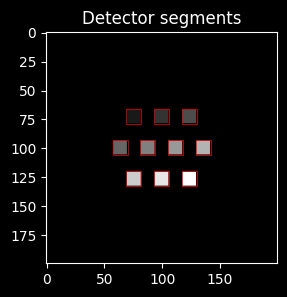

In [35]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(selected_detector_mask, cmap='grey')

for zone in get_zones_patches(selected_detector_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax0.add_patch(zone)

plt.show()

#### Датасет волновых фронтов

In [ ]:
# выбираем тип модуляциия (амплитудный или фазовый)
MODULATION_TYPE = 'amp'  # используем ТОЛЬКО амплитуду для кодирования каждого изображения в Wavefront!

In [ ]:
resize_y = int(DETECTOR_SIZE[0] / 3)
resize_x = int(DETECTOR_SIZE[1] / 3)  # shape для transforms.Resize
# Комментарий: Похоже, что в статье [2] изображения MNIST были изменены до размера ~100 x 100 нейронов.

# отступы по OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# отступы по OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [ ]:
# композиция всех трансформов!
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- select modulation type!!!
  ]
)

**<span style="color:red">Комментарий.</span>** Здесь `dataset.getitem()` вернёт пару `Wavefront`, где закодировано число, и метку цели (число от 0 до 9). В процессе обучения мы будем использовать среднеквадратичную потерю (MSE) и сгенерируем изображение детектора цели на основе зон детектора (будет инициализировано позже в 3.1.3).

In [ ]:
# тренировочный датасет волновых фронтов
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # датасет изображений
    transformations=image_transform_for_ds,  # трансформация изображений
    sim_params=SIM_PARAMS,  # параметры моделирования
    target='detector',
    detector_mask=DETECTOR_MASK
)

In [ ]:
# тестовый датасет волновых фронтов
mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=mnist_test_ds,  # датасет изображений
    transformations=image_transform_for_ds,  # трансформация изображений
    sim_params=SIM_PARAMS,  # параметры моделирования
    target='detector',
    detector_mask=DETECTOR_MASK
)

In [41]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


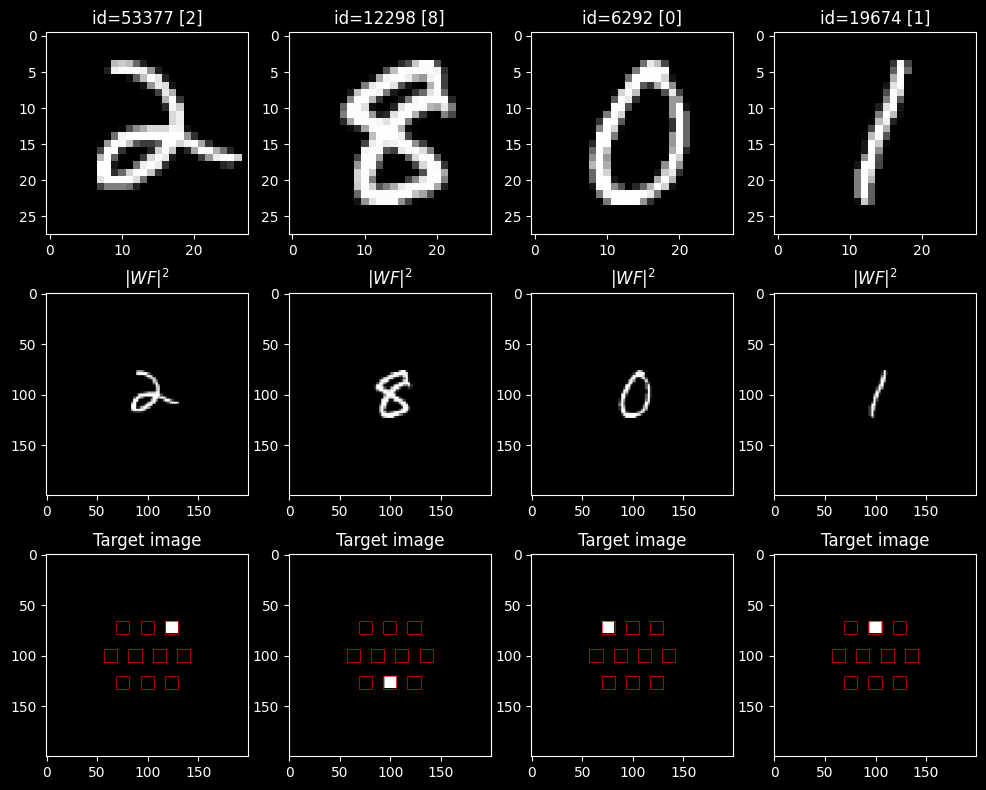

In [ ]:
# построение нескольких примеров тренировочного датасета
n_examples= 4  # число примеров
# индексы изображений
random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]

    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, target_image = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(
        wavefront.intensity, cmap='gray',
        vmin=0, vmax=1
    )

    # axs[2][ind_ex].set_title(f'phase of $WF$')
    # axs[2][ind_ex].imshow(
    #     wavefront.phase[0], cmap='gray',
    #     vmin=0, vmax= 2 * torch.pi
    # )

    axs[2][ind_ex].set_title(f'Target image')
    axs[2][ind_ex].imshow(
        target_image, cmap='gray',
        vmin=0, vmax= 1
    )

    for zone in get_zones_patches(selected_detector_mask):
        # add zone's patches to the axis
        # zone_copy = copy(zone)
        axs[2][ind_ex].add_patch(zone)

plt.show()

# 3. Оптическая нейросеть

Информация из дополнительных материалов [[1]](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) для классификации MNIST:

> Следуя дизайну $D^2NN$, осевое расстояние между двумя последовательными слоями, напечатанными на 3D-принтере, было установлено равным $3,0$ $см$...

> Расстояние между плоскостью детектора/выходного сигнала и последним слоем оптической нейронной сети было установлено равным $3$ $см$...

#### <span style="color:red">Дополнительно</span>

Из [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):

> ... осевое расстояние между последовательными дифракционными слоями устанавливается равным $\sim 40 \times \lambda$, как в [[1]](https://www.science.org/doi/10.1126/science.aat8084) ...

**<span style="color:red">Разница.</span>** Вы можете использовать другое количество дифракционных слоев (только для фазового обучения)!

In [43]:
NUM_OF_DIFF_LAYERS = 5  # number of diffractive layers
FREE_SPACE_DISTANCE = 40 * working_wavelength  # [m] - distance between difractive layers

In [44]:
print(f'Distance between layers is {FREE_SPACE_DISTANCE * 1e2:.3f} cm')

Distance between layers is 2.998 cm


## 3.1. Архитектура

См. Рис 2A из [[1]](https://www.science.org/doi/10.1126/science.aat8084).

См. Рис 1(a) из [[2]](https://ieeexplore.ieee.org/abstract/document/8732486).

### 3.1.1. Список элементов

In [46]:
MAX_PHASE = 2 * np.pi  # max phase for phase masks

**<span style="color:red">Из [1,2]: </span>**
> пятислойная дифракционная оптическая сеть, состоящая только из фаз (комплексных значений) ...

**<span style="color:red">Различие.</span>** Для `FreeSpace` в отличие от [2] используется другой пропагатор!

In [47]:
FREESPACE_METHOD = 'AS'  # we use another method in contrast to [2]!!!

**<span style="color:red">Данные из [2]: </span>**
> дифракционный слой ... нейроны ... были инициализированы с $\pi$ для значений фазы и $1$ для значений амплитуды ...

In [48]:
INIT_PHASES = torch.ones(NUM_OF_DIFF_LAYERS) * np.pi  # initial values for phase masks

**<span style="color:red">Комментарий</span>**

Здесь мы используем `ConstrainedParameter` по умолчанию, который использует сигмоиду для ограничения диапазона параметров.

В [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) авторы обсуждают такой подход в разделе «Результаты и обсуждение А.» и подчёркивают, что ограничение параметров с помощью сигмоидальной функции может привести к исчезающим градиентам. Авторы также предлагают другой способ ограничения параметров — с помощью ReLU.

В нашем случае сигмоидальная функция работает хорошо, но можно реализовать подход ReLU, указав `bound_func` для `Constrained Parameter` (<span style="color:red">примеры настройки `bound_func` приведены в ...</span>).

In [ ]:
# функции, возвращающие элементы для построения архитектуры:

def get_free_space(
    freespace_sim_params,
    freespace_distance,  # in [m]!
    freespace_method='AS',
):
    """
    возвращает слой FreeSpace с ограниченным параметром расстояния
    """
    return elements.FreeSpace(
        simulation_parameters=freespace_sim_params,
        distance=freespace_distance,  # distance is not learnable!
        method=freespace_method
    )


def get_const_phase_layer(
    sim_params: SimulationParameters,
    value, max_phase=2 * torch.pi
):
    """
    возвращает дифракционный слой DiffractiveLayer с постоянной фазовой маской.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value

    return elements.DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # здесь используется ограниченный параметр!
    )  # см документацию!

Функция построения списка элементов для воспроизведения архитектуры из [расширенной статьи](https://ieeexplore.ieee.org/abstract/document/8732486):

In [ ]:
def get_elements_list(
    num_layers,
    simulation_parameters,
    freespace_method,
    phase_values,
):
    """
    Составление списка элементов для оптической схемы.
    ...

    Parameters
    ----------
    num_layers : int
        Число слоев в системе.
    simulation_parameters : SimulationParameters()
        Параметры моделирования.
    freespace_method : str
        Метод для расчета распространения в однородном пространстве.
    phase_values : torch.Tensor()
        Torch tensor значений фазы для генерации постоянных масок для дифракционных слоев.

    Returns
    -------
    elements_list : list(Element)
        Список элементов оптической схемы.
    """
    elements_list = []  # list of elements

    # первый слой FreeSpace перед первым DiffractiveLayer
    elements_list.append(
        get_free_space(
            simulation_parameters,  # simulation parameters for the notebook
            FREE_SPACE_DISTANCE,  # in [m]
            freespace_method=freespace_method,
        )
    )

    # архитектура
    for ind_layer in range(num_layers):

        # -----------------------------------------------------------------------
        # добавить DiffractiveLayer (обучаемая фазовая маска)
        elements_list.append(
            get_const_phase_layer(
                simulation_parameters,  # simulation parameters for the notebook
                value=phase_values[ind_layer].item(),
                max_phase=MAX_PHASE
            )
        )
        # -----------------------------------------------------------------------

        # добавить FreeSpace
        elements_list.append(
            get_free_space(
                simulation_parameters,  # simulation parameters for the notebook
                FREE_SPACE_DISTANCE,  # in [m]
                freespace_method=freespace_method,
            )
        )

    # ---------------------------------------------------------------------------
    # добавление Detector в конце системы!
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # detector that returns intensity
        )
    )

    return elements_list

In [51]:
architecture_elements_list = get_elements_list(
    num_layers=NUM_OF_DIFF_LAYERS,
    simulation_parameters=SIM_PARAMS,
    freespace_method=FREESPACE_METHOD,
    phase_values=INIT_PHASES,
)

print(f'Number of elements in the system (including Detector): {len(architecture_elements_list)}')

Number of elements in the system (including Detector): 12


### 3.1.2. Задание `LinearOpticalSetup`

In [ ]:
def get_setup(simulation_parameters):
    """
    возвращает оптическую схему. создает заново все элементы.
    """
    elements_list = get_elements_list(
        num_layers=NUM_OF_DIFF_LAYERS,
        simulation_parameters=SIM_PARAMS,
        freespace_method=FREESPACE_METHOD,
        phase_values=INIT_PHASES,
    )  # recreate a list of elements

    return LinearOpticalSetup(elements=elements_list)

In [ ]:
# создать оптическую схему
optical_setup = get_setup(SIM_PARAMS)

In [54]:
optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (2): FreeSpace()
  (3): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (4): FreeSpace()
  (5): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (6): FreeSpace()
  (7): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (8): FreeSpace()
  (9): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (10): FreeSpace()
  (11): Detector()
)

**<span style="color:red">Комментарий:</span>** Схема заканчивается элементом `Detector` который возвращает выходной тензор интенсивностей для каждого входного `Wavefront`.

#### Пример расчета распространения волнового фронта

In [55]:
example_wf = mnist_wf_train_ds[128][0]

In [56]:
setup_scheme, wavefronts = optical_setup.stepwise_forward(example_wf)

-(0)-> [1. FreeSpace] -(1)-> [2. DiffractiveLayer] -(2)-> [3. FreeSpace] -(3)-> [4. DiffractiveLayer] -(4)-> [5. FreeSpace] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. DiffractiveLayer] -(8)-> [9. FreeSpace] -(9)-> [10. DiffractiveLayer] -(10)-> [11. FreeSpace] -(11)-> [12. Detector] -(12)->


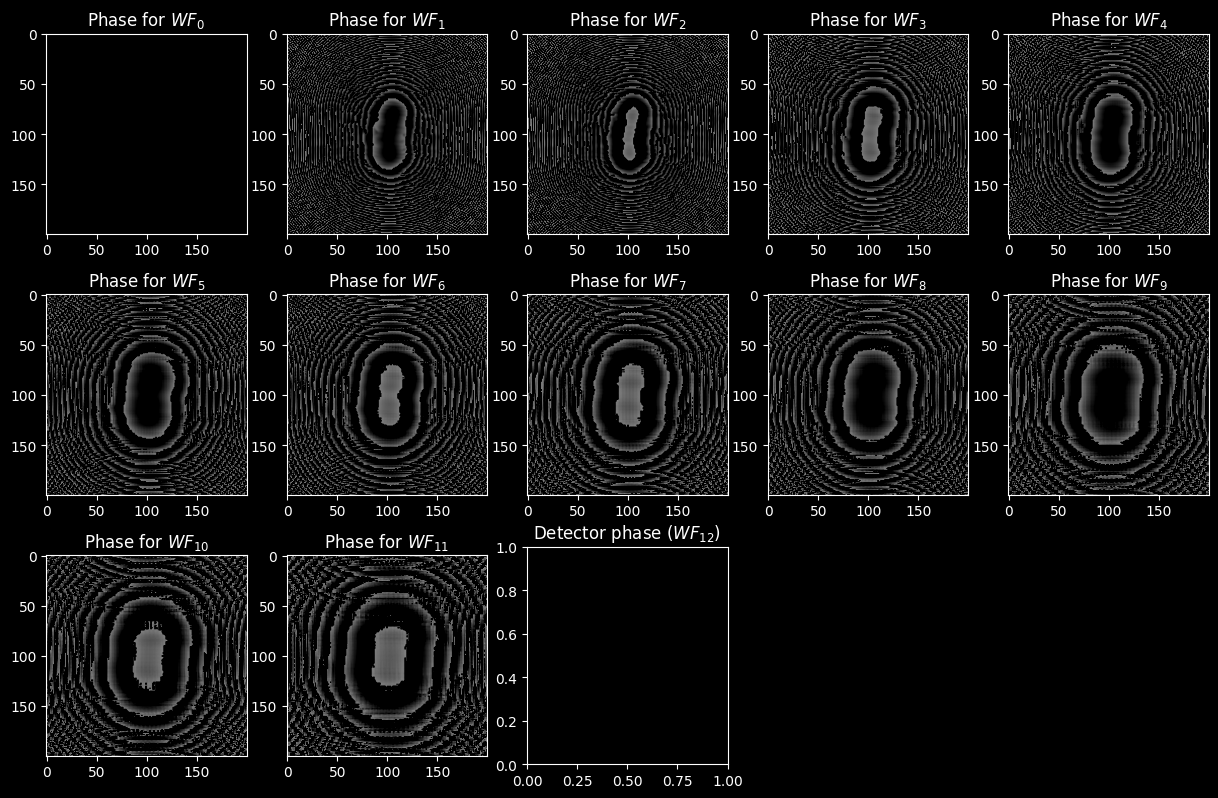

In [ ]:
print(setup_scheme)  # печать схемы

n_cols = 5  # число столбцов для постронения всех волновых фронтов при распространении
n_rows = (len(optical_setup.net) // n_cols) + 1

to_plot = 'phase'  # <--- что строим
cmap = 'grey'  # цветовая схема
detector_cmap = 'hot'

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# убираем ненужные оси
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(wavefronts):
            ax_this.axis('off')

# построение волновых фронтов
for ind_wf, wavefront in enumerate(wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    if to_plot == 'phase':
        # построение фазы, поскольку картины интенсивности неразличимы
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Phase for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (не волновой фронт!)
            ax_this.set_title('Detector phase ($WF_{' + f'{ind_wf}' + '})$')
            # на детекторе нет фазы!

    if to_plot == 'amp':
        # построение фазы, поскольку картины интенсивности неразличимы
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # разкомментировать, чтобы сделать пределы одинаковыми
            )
        else:  #  выход Detector (не волновой фронт!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront.detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # разкомментировать, чтобы сделать пределы одинаковыми
            )

    # Комментарий: выход детектора - Tensor! У него нет методов Wavefront (фаза или интенсивность)!

plt.show()

### 3.1.3 Обработчик детектора (Detector processor) (для расчета точности)

> ... размеры детекторов $(6.4 \lambda \times 6.4 \lambda)$ ...

**<span style="color:red">Комментарий:</span>** `DetectorProcessor` в нашей библиотеке используется для обработки информации на детекторе. Например, для текущей задачи `DetectorProcessor` должен вернуть только 10 значений (по одному значению на 1 класс).

In [ ]:
CALCULATE_ACCURACIES = True  # если False, точности не вычисляются!

In [ ]:
# создать объект DetectorProcessorOzcanClf
if CALCULATE_ACCURACIES:
    detector_processor = DetectorProcessorClf(
        simulation_parameters=SIM_PARAMS,
        num_classes=number_of_classes,
        segmented_detector=DETECTOR_MASK,
    )
else:
    detector_processor = None

# 4. Обучение сети

Текущие переменные:
- `lin_optical_setup` : `LinearOpticalSetup` – линейная оптическая сеть, составленная из Elements
- `detector_processor` : `DetectorProcessorClf` – этот слой обрабатывает изображение с детектора и вычисляет вероятности принадлежности классам.

In [ ]:
DEVICE = 'cpu'  # 'mps' is not support a CrossEntropyLoss

In [62]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

'cpu'

## 4.1. Препроцессинг

### 4.1.1. `DataLoader`

Информация из дополнительных материалов [[1]](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) для классификации MNIST:

> Размер батча выл выбран равным $8$...

In [ ]:
train_bs = 8  # размер батча для обучающей выборки
val_bs = 20

> Для этой задачи были разработаны маски пропускания только фазы путем обучения пятислойной нейронной сети $D^2$ с $55000$ изображениями ($5000$ проверочными изображениями) из базы данных рукописных цифр MNIST.

In [64]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(178)  # for reproducibility
)

In [65]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Оптимизатор и функция потерь

Информация из дополнительных материалов [[1]](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) для классификации MNIST:

> Мы использовали алгоритм стохастического градиентного спуска Adam для обратного распространения ошибок и обновления слоев сети с целью минимизации функции потерь.

**<span style="color:red">Дополнительно</span>** из [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):
> метод обратного распространения с применением адаптивного оптимизатора оценки момента (Adam) со скоростью обучения $10^{−3}$

In [66]:
LR = 1e-3

In [67]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # NETWORK PARAMETERS!
        lr=LR
    )

**<span style="color:red">Комментарий:</span>** Мы используем `MSELoss`, как в [1] (это было разъяснено в [2])! 

In [68]:
loss_func_clf = nn.MSELoss()  # by default: reduction='mean'
loss_func_name = 'MSE'

### 4.1.3. Циклы обучения и оценки

In [ ]:
def onn_train_mse(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # DETECTOR PROCESSOR нужен только для оценки точности!
    loss_func, optimizer,
    device='cpu', show_process=False
):
    """
    функция для тренировки `optical_net` (задача классификации)
    ...

    Parameters
    ----------
        optical_net : torch.nn.Module
            Neural Network составленная из Elements.
        wavefronts_dataloader : torch.utils.data.DataLoader
            Загрузчик (по батчам) для тренирововчного датасета волновых фронтов.
        detector_processor_clf : DetectorProcessorClf
            Обработчик изображений детектора для задачи классификации, возвращающий `вероятности` классов.
        loss_func :
            функция потерь.
        optimizer: torch.optim
            оптимизатор
        device : str
            Девайс, на котором производятся расчеты...
        show_process : bool
            флаг для прогресс-бара.

    Returns
    -------
        batches_losses : list[float]
            потери для каждого батча в эпохе.
        batches_accuracies : list[float]
            точность для каждого батча в эпохе.
        epoch_accuracy : float
            точность на эпохе.
    """
    optical_net.train()  # активация режима 'обучения'
    batches_losses = []  # для хранения батчей
    batches_accuracies = []  # для хранения точности батчей

    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_targets in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='train', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]

        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()

        # forward of an optical network
        detector_output = optical_net(batch_wavefronts)

        # calculate loss for a batch
        loss = loss_func(detector_output, batch_targets)

        loss.backward()
        optimizer.step()

        # ACCURACY
        if CALCULATE_ACCURACIES:
            # process a detector image
            batch_labels = detector_processor_clf.batch_forward(batch_targets).argmax(1)
            batch_probas = detector_processor_clf.batch_forward(detector_output)

            batch_correct_preds = (
                batch_probas.argmax(1) == batch_labels
            ).type(torch.float).sum().item()

            correct_preds += batch_correct_preds
            size += batch_size

        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        if CALCULATE_ACCURACIES:
            batches_accuracies.append(batch_correct_preds / batch_size)
        else:
            batches_accuracies.append(0.)

    if CALCULATE_ACCURACIES:
        epoch_accuracy = correct_preds / size
    else:
        epoch_accuracy = 0.

    return batches_losses, batches_accuracies, epoch_accuracy

In [ ]:
def onn_validate_mse(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # DETECTOR PROCESSOR NEEDED!
    loss_func,
    device='cpu', show_process=False
    ):
    """
    Function to validate `optical_net` (classification task)
    ...

    Parameters
    ----------
        optical_net : torch.nn.Module
            Neural Network composed of Elements.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        detector_processor_clf : DetectorProcessorClf
            A processor of a detector image for a classification task, that returns `probabilities` of classes.
        loss_func :
            Loss function for a multi-class classification task.
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.

    Returns
    -------
        batches_losses : list[float]
            Losses for each batch in an epoch.
        batches_accuracies : list[float]
            Accuracies for each batch in an epoch.
        epoch_accuracy : float
            Accuracy for an epoch.
    """
    optical_net.eval()  # activate 'eval' mode of a model
    batches_losses = []  # to store loss for each batch
    batches_accuracies = []  # to store accuracy for each batch

    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_targets in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='validation', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]

        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)

        with torch.no_grad():
            detector_outputs = optical_net(batch_wavefronts)
            # calculate loss for a batch
            loss = loss_func(detector_outputs, batch_targets)

        # ACCURACY
        if CALCULATE_ACCURACIES:
            # process a detector image
            batch_labels = detector_processor_clf.batch_forward(batch_targets).argmax(1)
            batch_probas = detector_processor_clf.batch_forward(detector_outputs)

            batch_correct_preds = (
                batch_probas.argmax(1) == batch_labels
            ).type(torch.float).sum().item()

            correct_preds += batch_correct_preds
            size += batch_size

        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        if CALCULATE_ACCURACIES:
            batches_accuracies.append(batch_correct_preds / batch_size)
        else:
            batches_accuracies.append(0.)

    if CALCULATE_ACCURACIES:
        epoch_accuracy = correct_preds / size
    else:
        epoch_accuracy = 0.

    return batches_losses, batches_accuracies, epoch_accuracy

## 4.2. Обучение оптической сети

### 4.2.1. Перед обучением

> дифракционный слой ... нейроны ... были инициализированы с $\pi$ для значений фазы и $1$ для значений амплитуды ...

#### Метрики для тестового датасета

In [ ]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)  # загрузчик данных для данных MNIST

In [73]:
# lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)
# SIM_PARAMS = SIM_PARAMS.to(DEVICE)

In [ ]:
test_losses_0, _, test_accuracy_0 = onn_validate_mse(
    optical_setup.net,  # оптическая сеть из раздела 3.
    test_wf_loader,  # dataloader для тренирововчного датасета
    detector_processor,  # обработчик детектора
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # оценка модели

print(
    'Results before training on TEST set:\n' +
    f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_0*100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 41.91it/s]

Results before training on TEST set:
	MSE : 0.004722
	Accuracy : 8.2 %


### 4.2.2. Обучение

In [ ]:
n_epochs = 20
print_each = 2  # печатать информацию каждую print_each эпоху

In [ ]:
scheduler = None  # планировщик для настройки LR во время обучения

In [ ]:
# Воссоздайте систему для возобновления обучения!
ozcan_optical_setup = get_setup(SIM_PARAMS)

# оптимизатор для воссозданной сети!
optimizer_clf = get_adam_optimizer(ozcan_optical_setup.net)

In [83]:
# lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)

In [ ]:
train_epochs_losses = []
val_epochs_losses = []  # для сохранения потерь на каждой эпохе

train_epochs_acc = []
val_epochs_acc = []  # для  сохранения точности

torch.manual_seed(98)  # для воспроизводимости

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # TRAIN
    start_train_time = time.time()  # start time of the epoch (train)
    train_losses, _, train_accuracy = onn_train_mse(
        ozcan_optical_setup.net,  # optical network composed in 3.
        train_wf_loader,  # dataloader of training set
        detector_processor,  # detector processor
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # train the model
    mean_train_loss = np.mean(train_losses)

    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # train info
        print('Training results')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        if CALCULATE_ACCURACIES:
            print(f'\tAccuracy : {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # VALIDATION
    start_val_time = time.time()  # start time of the epoch (validation)
    val_losses, _, val_accuracy = onn_validate_mse(
        ozcan_optical_setup.net,  # optical network composed in 3.
        val_wf_loader,  # dataloader of validation set
        detector_processor,  # detector processor
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # evaluate the model
    mean_val_loss = np.mean(val_losses)

    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # validation info
        print('Validation results')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        if CALCULATE_ACCURACIES:
            print(f'\tAccuracy : {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} s')

    if scheduler:
        scheduler.step(mean_val_loss)

    # save losses
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)
    # seve accuracies
    train_epochs_acc.append(train_accuracy)
    val_epochs_acc.append(val_accuracy)

Epoch #1: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [07:59<00:00, 14.34it/s]


Training results
	MSE : 0.002594
	Accuracy : 70.4 %
	------------   479.40 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:18<00:00, 13.62it/s]


Validation results
	MSE : 0.002151
	Accuracy : 78.6 %
	------------   18.36 s
Epoch #2: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [05:54<00:00, 19.37it/s]


Training results
	MSE : 0.002038
	Accuracy : 80.5 %
	------------   354.95 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:18<00:00, 13.82it/s]


Validation results
	MSE : 0.001983
	Accuracy : 79.5 %
	------------   18.09 s
Epoch #4: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:56<00:00, 16.51it/s]


Training results
	MSE : 0.001887
	Accuracy : 81.8 %
	------------   416.51 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 13.06it/s]


Validation results
	MSE : 0.001883
	Accuracy : 81.3 %
	------------   19.14 s
Epoch #6: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:47<00:00, 16.86it/s]


Training results
	MSE : 0.001840
	Accuracy : 82.2 %
	------------   407.76 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 12.59it/s]


Validation results
	MSE : 0.001845
	Accuracy : 81.6 %
	------------   19.86 s
Epoch #8: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [07:03<00:00, 16.24it/s]


Training results
	MSE : 0.001816
	Accuracy : 82.6 %
	------------   423.47 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:20<00:00, 12.13it/s]


Validation results
	MSE : 0.001825
	Accuracy : 82.0 %
	------------   20.61 s
Epoch #10: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [07:09<00:00, 16.00it/s]


Training results
	MSE : 0.001801
	Accuracy : 82.7 %
	------------   429.77 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:23<00:00, 10.74it/s]


Validation results
	MSE : 0.001811
	Accuracy : 81.5 %
	------------   23.27 s
Epoch #12: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:59<00:00, 16.39it/s]


Training results
	MSE : 0.001790
	Accuracy : 82.8 %
	------------   419.44 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:20<00:00, 11.98it/s]


Validation results
	MSE : 0.001801
	Accuracy : 82.0 %
	------------   20.87 s
Epoch #14: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:48<00:00, 16.83it/s]


Training results
	MSE : 0.001783
	Accuracy : 83.0 %
	------------   408.38 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 12.61it/s]


Validation results
	MSE : 0.001794
	Accuracy : 82.2 %
	------------   19.83 s
Epoch #16: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:43<00:00, 17.02it/s]


Training results
	MSE : 0.001777
	Accuracy : 83.0 %
	------------   403.87 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 12.56it/s]


Validation results
	MSE : 0.001792
	Accuracy : 81.9 %
	------------   19.91 s
Epoch #18: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:00<00:00, 19.07it/s]


Training results
	MSE : 0.001772
	Accuracy : 83.0 %
	------------   360.47 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:18<00:00, 13.76it/s]


Validation results
	MSE : 0.001786
	Accuracy : 82.1 %
	------------   18.17 s
Epoch #20: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [05:57<00:00, 19.20it/s]


Training results
	MSE : 0.001769
	Accuracy : 83.1 %
	------------   358.00 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:17<00:00, 14.36it/s]

Validation results
	MSE : 0.001783
	Accuracy : 82.2 %
	------------   17.42 s


#### Кривые обучения (MSELoss и Accuracy)

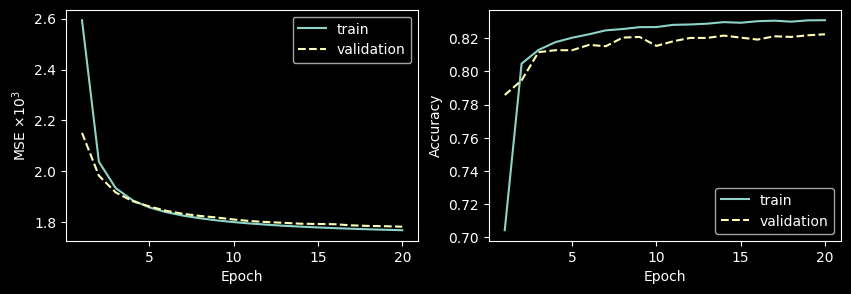

In [85]:
# learning curve
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), np.array(train_epochs_losses) * 1e3, label='train')
axs[0].plot(range(1, n_epochs + 1), np.array(val_epochs_losses) * 1e3, linestyle='dashed', label='validation')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name + r' $\times 10^3$')
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

In [ ]:
# array with all losses
# TODO: make with PANDAS?
all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T

#### Обученные фазовые маски

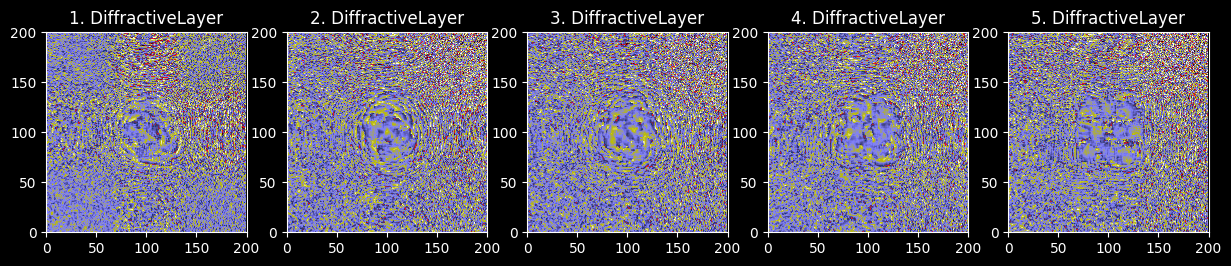

In [ ]:
n_cols = NUM_OF_DIFF_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'  # 'gist_stern' 'rainbow'

for ind_layer, layer in enumerate(ozcan_optical_setup.net):
    if isinstance(layer, elements.DiffractiveLayer):  # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_diff_layer + 1}. DiffractiveLayer')

        trained_mask = layer.mask.detach()

        ax_this.imshow(
            trained_mask, cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

    # select only a part within apertures!
    x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
    y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
    ax_this.set_xlim([x_frame, x_layer_nodes - x_frame])
    ax_this.set_ylim([y_frame, y_layer_nodes - y_frame])

plt.show()

### 4.2.3. Сохранение результатов

#### Патчи

In [89]:
RESULTS_FOLDER = 'models/reproduced_results/MNIST_MSE_Ozcan_2018-2020'

if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [90]:
# filepath to save the model
model_filepath = f'{RESULTS_FOLDER}/optical_setup_net.pth'
# filepath to save losses
losses_filepath = f'{RESULTS_FOLDER}/training_curves.csv'

#### Сохранение весов модели и кривых обучения

In [91]:
# saving model
# torch.save(ozcan_optical_setup.net.state_dict(), model_filepath)

In [92]:
# saving losses
# np.savetxt(
#     losses_filepath, all_losses_array,
#     delimiter=',', header=all_lasses_header, comments=""
# )

# 5. Загрузка сохраненных весов модели

In [93]:
RESULTS_FOLDER = 'models/reproduced_results/MNIST_MSE_Ozcan_2018-2020'

load_model_filepath = f'{RESULTS_FOLDER}/optical_setup_net.pth'

In [94]:
# setup to load weights
ozcan_optical_setup_loaded = get_setup(SIM_PARAMS)

# LOAD WEIGHTS
ozcan_optical_setup_loaded.net.load_state_dict(torch.load(load_model_filepath))

/var/folders/mt/0w6nmsr119bb2g4h4xrv9p6m0000gn/T/ipykernel_6050/484346891.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ozcan_optical_setup_loaded.net.load_state_dict(

<All keys matched successfully>

## 5.1. Рассчитать метрики на тестовом наборе для загруженной модели

Проверяем корректность работы загруженной модели!

In [ ]:
test_losses_1, _, test_accuracy_1 = onn_validate_mse(
    ozcan_optical_setup_loaded.net,  # optical network with loaded weights
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results after training on TEST set:\n' +
    f'\t{loss_func_name} : {np.mean(test_losses_1):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_1 * 100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.67it/s]

Results after training on TEST set:
	MSE : 0.001732
	Accuracy : 83.6 %


## 5.2. Пример классификации (распространение через обученную оптическую схему)

### 5.2.1. Выбор изображения

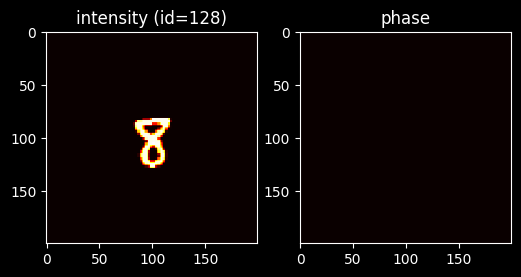

In [96]:
# plot an image
# '1' - 3214, good
# '4' - 6152, good
# '6' - 123, good
# '8' - 128, good
# '0' - 3, good
ind_test = 128
cmap = 'hot'

fig, axs = plt.subplots(1, 2, figsize=(2 * 3, 3))

test_wavefront, test_target = mnist_wf_test_ds[ind_test]

axs[0].set_title(f'intensity (id={ind_test})')
axs[0].imshow(test_wavefront.intensity, cmap=cmap)

axs[1].set_title(f'phase')
axs[1].imshow(
    test_wavefront.phase, cmap=cmap,
    vmin=0, vmax=2 * torch.pi
)

plt.show()

In [97]:
# propagation of the example through the trained network
setup_scheme, test_wavefronts = ozcan_optical_setup_loaded.stepwise_forward(test_wavefront)

### 5.2.2. Амплитудные профили

-(0)-> [1. FreeSpace] -(1)-> [2. DiffractiveLayer] -(2)-> [3. FreeSpace] -(3)-> [4. DiffractiveLayer] -(4)-> [5. FreeSpace] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. DiffractiveLayer] -(8)-> [9. FreeSpace] -(9)-> [10. DiffractiveLayer] -(10)-> [11. FreeSpace] -(11)-> [12. Detector] -(12)->


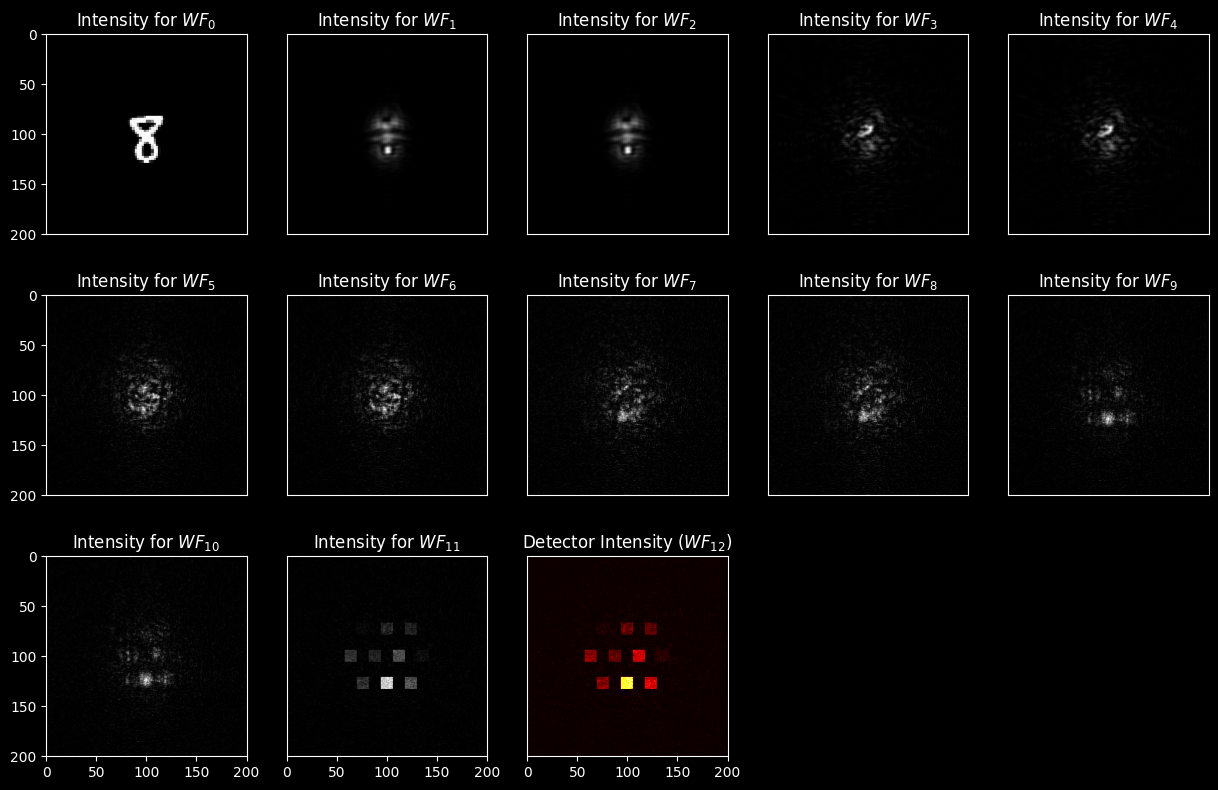

In [ ]:
print(setup_scheme)  # prints propagation scheme

n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = (len(ozcan_optical_setup_loaded.net) // n_cols) + 1

to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'  # choose colormaps
detector_cmap = 'hot'

within_aperture = True  # if true plots only the field which is within apertures!

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(test_wavefronts):
            ax_this.axis('off')

# plot wavefronts
for ind_wf, wavefront in enumerate(test_wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    # delete unnecessary ticks
    if not (ind_wf // n_cols) == n_rows - 1:
        ax_this.set_xticks([])
    if not (ind_wf % n_cols) == 0:
        ax_this.set_yticks([])

    if to_plot == 'phase':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Phase for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (not a wavefront!)
            ax_this.set_title('Detector phase ($WF_{' + f'{ind_wf}' + '})$')
            # Detector has no phase!

    if to_plot == 'amp':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(test_wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
        else:  # Detector output (not a wavefront!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront.detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )

    # Comment: Detector output is Tensor! It has no methods of Wavefront (like .phase or .intensity)!
    if within_aperture:
        # select only a part within apertures!
        x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
        y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
        ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

### 5.2.3. Изображение на детекторе

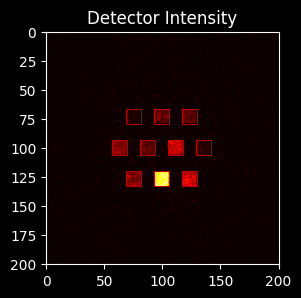

In [99]:
# create a figure with subplots
fig, ax_this = plt.subplots(1, 1, figsize=(3, 3.2))

# Detector output (not a wavefront!)
ax_this.set_title('Detector Intensity')
ax_this.imshow(
    test_wavefronts[-1].detach().numpy(), cmap='hot',
    # vmin=0, vmax=1  # uncomment to make the same limits
)

for zone in get_zones_patches(selected_detector_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax_this.add_patch(zone)

# select only a part within apertures!
x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
plt.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

In [ ]:
# get probabilities of an example classification
if detector_processor:
    test_probas = detector_processor.forward(test_wavefronts[-1])
    # Comment: forward() method is from DetectorProcessorClf
    #          p_i = I(detector_i) / sum_j(I(detector_j))

    assert np.isclose(test_probas.sum().item(), 1)

    for label, prob in enumerate(test_probas[0]):
        print(f'{label} : {prob * 100:.2f}%')

0 : 1.21%
1 : 5.78%
2 : 5.33%
3 : 8.52%
4 : 5.84%
5 : 13.06%
6 : 2.05%
7 : 8.20%
8 : 36.26%
9 : 13.75%


## 5.3. _Эффективность_

### 5.3.1. Предсказать все тестовые наборы данных и сохранить все результаты

In [ ]:
targets_test_lst = []
preds_test_lst = []

detector_sums_by_classes = [
    torch.zeros(size=SIM_PARAMS.axes_size(axs=('H', 'W'))) for _ in range(number_of_classes)
]
samples_by_classes = [0 for _ in range(number_of_classes)]
probas_sums_by_classes = [
    torch.zeros(number_of_classes) for _ in range(number_of_classes)
]

# loop over the test dataset
for ind, (wavefront_this, target_this) in enumerate(tqdm(mnist_wf_test_ds)):
    ozcan_optical_setup_loaded.net.eval()

    batch_wavefronts = torch.unsqueeze(wavefront_this, 0)
    batch_targets = torch.unsqueeze(torch.tensor(target_this), 0)  # to use forwards for batches

    batch_labels = detector_processor.batch_forward(batch_targets).argmax(1)

    with torch.no_grad():
        detector_output = ozcan_optical_setup_loaded.net(batch_wavefronts)
        # process a detector image
        batch_probas = detector_processor.batch_forward(detector_output)

        for ind_in_batch in range(batch_labels.size()[0]):
            label_this = batch_labels[ind_in_batch].item()  # true label
            targets_test_lst.append(label_this)

            detector_sums_by_classes[label_this] += detector_output[ind_in_batch]
            probas_sums_by_classes[label_this] += batch_probas[ind_in_batch]
            samples_by_classes[label_this] += 1

            preds_test_lst.append(batch_probas[ind_in_batch].argmax().item())

  0%|                                                                                              | 0/10000 [00:00<?, ?it/s]/var/folders/mt/0w6nmsr119bb2g4h4xrv9p6m0000gn/T/ipykernel_6050/4020111491.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_targets = torch.unsqueeze(torch.tensor(target_this), 0)  # to use forwards for batches
100%|█████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:53<00:00, 185.43it/s]


### 5.3.2. Матрица ошибок

In [103]:
for class_ind in range(number_of_classes):
    probas_sums_by_classes[class_ind] /= samples_by_classes[class_ind]

In [104]:
avg_probas_mat = torch.zeros(size=(number_of_classes, number_of_classes))

for ind_class in range(number_of_classes):
    avg_probas_mat[ind_class, :] = probas_sums_by_classes[ind_class]

In [105]:
# ordinary confusion matrix
confusion_matrix = torch.zeros(size=(number_of_classes, number_of_classes), dtype=torch.int32)

for ind in range(len(mnist_wf_test_ds)):
    confusion_matrix[targets_test_lst[ind], preds_test_lst[ind]] += 1

#### Построение матрицы ошибок

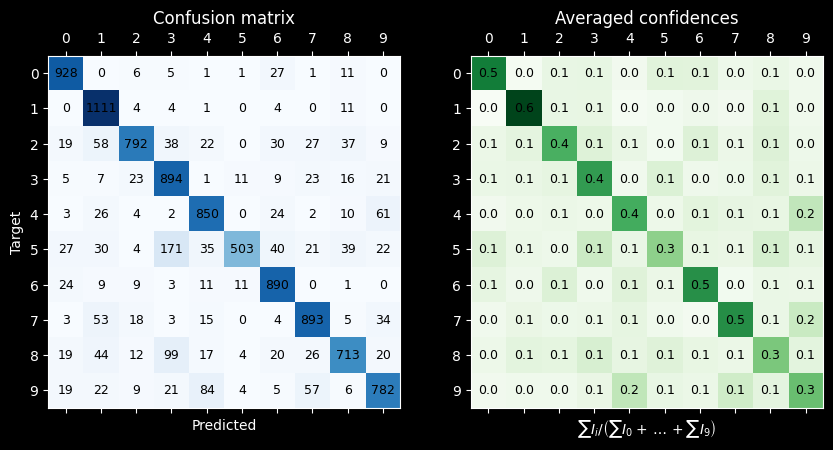

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# CONFUSION MATRIX
ax0.set_title('Confusion matrix')
ax0.matshow(confusion_matrix, cmap='Blues')

for i in range(number_of_classes):
    for j in range(number_of_classes):
        val = confusion_matrix[j, i].item()
        ax0.text(
            i, j, str(val),
            va='center', ha='center',
            c='k', fontsize=9
        )

ax0.set_ylabel('Target')
ax0.set_xlabel('Predicted')

ax0.set_xticks(range(number_of_classes))
ax0.set_yticks(range(number_of_classes))

# AVERAGED PREDICTED PROBAS
ax1.set_title('Averaged confidences')
ax1.matshow(avg_probas_mat, cmap='Greens')

for i in range(number_of_classes):
    for j in range(number_of_classes):
        val = avg_probas_mat[j, i].item()
        ax1.text(
            i, j, f'{val:.1f}',
            va='center', ha='center',
            c='k', fontsize=9
        )

ax1.set_xlabel(r'$\sum I_i / \left( \sum I_0 + \dots + \sum I_9 \right)$')

ax1.set_xticks(range(number_of_classes))
ax1.set_yticks(range(number_of_classes))
# ax1.set_yticks(range(number_of_classes), labels=['' for _ in range(number_of_classes)])

plt.show()

# save figure
# fig.savefig(f'{RESULTS_FOLDER}/confusion_matrix.png', bbox_inches='tight')

### 5.3.3. Усредненный детектор для выбранного класса

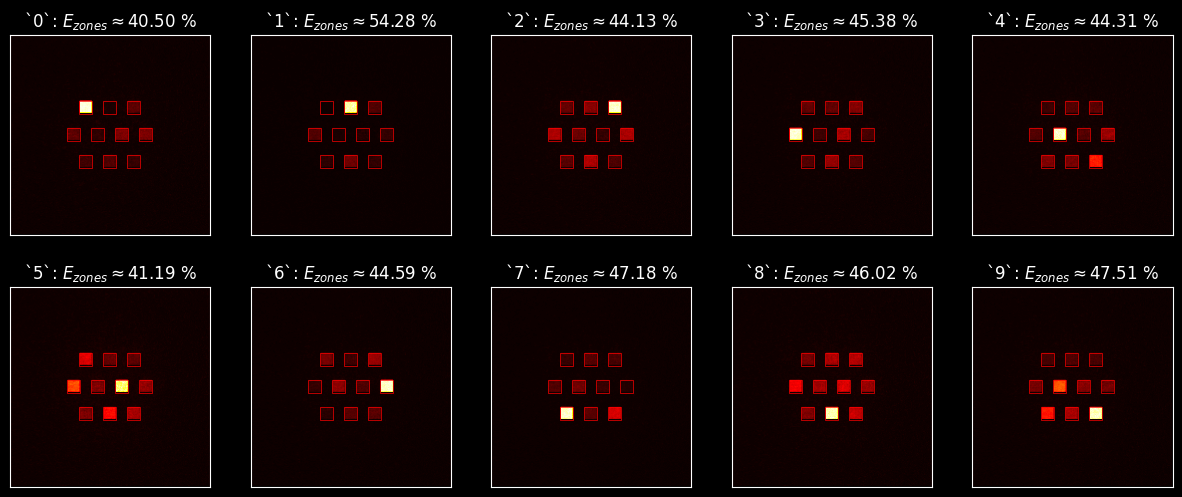

In [ ]:
n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = (number_of_classes // n_cols)

detector_cmap = 'hot'

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= number_of_classes:
            ax_this.axis('off')

# plot wavefronts
for selected_class in range(number_of_classes):
    ax_this = axs[selected_class // n_cols][selected_class % n_cols]

    # focus "efficiency"
    int_over_detector_zones = 0

    for ind_class in range(number_of_classes):
        int_over_detector_zones += detector_processor.batch_zone_integral(
            detector_sums_by_classes[selected_class].unsqueeze(0).unsqueeze(0),
            ind_class=ind_class,
        )[0].item()

    detector_int = detector_sums_by_classes[selected_class].sum().item()
    detector_efficiency = int_over_detector_zones / detector_int

    # Detector output (not a wavefront!)
    ax_this.set_title(
        f'`{selected_class}`: ' + r'$E_{zones}\approx$' +
        f'{detector_efficiency * 100:.2f} %'
    )
    ax_this.imshow(
        detector_sums_by_classes[selected_class] / samples_by_classes[selected_class],
        cmap=detector_cmap,
        # vmin=0, vmax=0.02  # uncomment to make the same limits
    )

    for zone in get_zones_patches(selected_detector_mask):
        # add zone's patches to the axis
        # zone_copy = copy(zone)
        ax_this.add_patch(zone)

    ax_this.set_xticks([])
    ax_this.set_yticks([])

    # select only a part within apertures!
    x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
    y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
    ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

# save figure
# fig.savefig(f'{RESULTS_FOLDER}/averaged_detector_for_classes.png', bbox_inches='tight')

### 5.6.3. _Эффективность_ детектора

$$
\frac{\sum\limits_{\text{class}=0}^9 \left( \iint\limits_{S_\text{class}} I(x,y) \right)}{\iint\limits_{S_\text{detector}} I(x,y)}
$$

In [ ]:
detector_efficiency_by_classes = {}

for selected_class in range(number_of_classes):
    int_over_detector_zones = 0

    for ind_class in range(number_of_classes):
        int_over_detector_zones += detector_processor.batch_zone_integral(
            detector_sums_by_classes[selected_class].unsqueeze(0).unsqueeze(0),
            ind_class=ind_class,
        )[0].item()

    detector_int = detector_sums_by_classes[selected_class].sum().item()
    detector_efficiency_by_classes[selected_class] = int_over_detector_zones / detector_int

In [111]:
detector_efficiency_by_classes

{0: 0.4050211291136659,
 1: 0.5428157458607163,
 2: 0.4413072501691072,
 3: 0.4538277032916947,
 4: 0.4431350506348938,
 5: 0.41187030938721453,
 6: 0.4459388775152231,
 7: 0.4718425602504195,
 8: 0.46020362599016984,
 9: 0.47513783929077924}